In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils import chamfer_loss
from fspool import FSPool
from model import FSEncoder
from model import MaxEncoder
from MnistSet import MNISTSet
from MnistSet import get_loader

### Preparamos los datos de entreno y test

In [3]:
batch_size = 32

In [4]:
train_loader = get_loader(
            MNISTSet(train=True, full=True), batch_size=batch_size, num_workers=4)

In [5]:
test_loader = get_loader(
            MNISTSet(train=False, full=True), batch_size=batch_size, num_workers=4)

In [6]:
from time import sleep
from tqdm import tqdm

In [7]:
set_channels = 2
set_size = 342
  
hidden_dim = 32
iters = 10
latent_dim = 16
lr = 0.001
n_epochs = 100
net = MaxEncoder(set_channels,latent_dim,hidden_dim)

In [7]:
net

MaxEncoder(
  (conv): Sequential(
    (0): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
  )
  (lin): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [8]:
optimizer = torch.optim.Adam([p for p in net.parameters() if p.requires_grad], lr=0.001)

In [9]:
#net = net.cuda()

In [10]:
net.train()
for epoch in range(n_epochs):
    with tqdm(train_loader, unit="batch") as tepoch:
        for i, sample in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            input, target_set, target_mask = map(lambda x: x, sample)
            optimizer.zero_grad()
            output = net(target_set,target_mask)
            loss = F.cross_entropy(output, input)
            acc = (output.max(dim=1)[1] == input).float().mean()
            loss.backward()
            optimizer.step()
            tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())

Epoch 99: 100%|███████████████████████████████████████████████| 1875/1875 [01:13<00:00, 25.53batch/s, acc=84.4, loss=0.265]


In [11]:
net.eval()
with tqdm(test_loader, unit="batch") as tepoch:
    for i, sample in enumerate(tepoch):
        tepoch.set_description(f"Epoch {1}")
        input, target_set, target_mask = map(lambda x: x, sample)
        output = net(target_set,target_mask)
        loss = F.cross_entropy(output, input)
        acc = (output.max(dim=1)[1] == input).float().mean()
        tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())

Epoch 1: 100%|██████████████████████████████████████████████████| 312/312 [00:08<00:00, 37.03batch/s, acc=100, loss=0.0594]


In [12]:
#torch.save(net.state_dict(),'model_max_encoder.pth')

In [8]:
model = torch.load('model_max_encoder.pth' ,map_location=torch.device('cpu'))
miNet = MaxEncoder(set_channels,latent_dim,hidden_dim)

In [9]:
miNet.load_state_dict(torch.load('model_max_encoder.pth' ,map_location=torch.device('cpu')))

<All keys matched successfully>

In [10]:
miNet

MaxEncoder(
  (conv): Sequential(
    (0): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
  )
  (lin): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [11]:
miNet.eval()
with tqdm(test_loader, unit="batch") as tepoch:
    for i, sample in enumerate(tepoch):
        tepoch.set_description(f"Epoch {1}")
        input, target_set, target_mask = map(lambda x: x, sample)
        output = miNet(target_set,target_mask)
        loss = F.cross_entropy(output, input)
        acc = (output.max(dim=1)[1] == input).float().mean()
        tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())

Epoch 1: 100%|███████| 312/312 [00:08<00:00, 36.45batch/s, acc=90.6, loss=0.242]


In [12]:
import seaborn as sn
import matplotlib
import matplotlib.pyplot as pyplot
import numpy as np

In [13]:
miNet

MaxEncoder(
  (conv): Sequential(
    (0): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
  )
  (lin): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

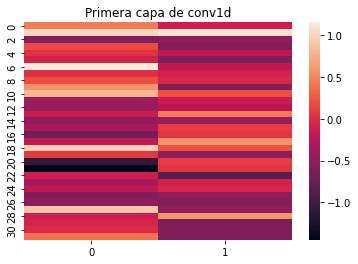

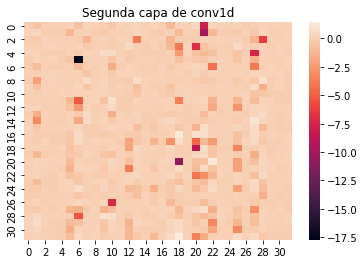

In [14]:
filters= miNet.conv[0].weight
data = filters.squeeze(2).detach().numpy()
sn.heatmap(data, annot=False, fmt='g')
pyplot.title("Primera capa de conv1d")
pyplot.show()
filters= miNet.conv[2].weight
data = filters.squeeze(2).detach().numpy()
sn.heatmap(data, annot=False, fmt='g')
pyplot.title("Segunda capa de conv1d")
pyplot.show()

torch.Size([32, 32])


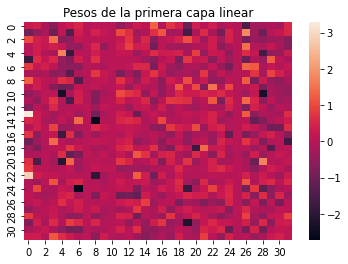

In [15]:
filters= miNet.lin[0].weight
print(filters.shape)
data = filters.detach().numpy()
sn.heatmap(data, annot=False, fmt='g')
pyplot.title("Pesos de la primera capa linear")
pyplot.show()

torch.Size([16, 32])


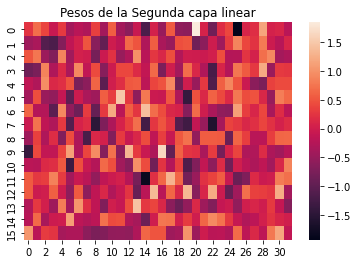

In [16]:
filters= miNet.lin[2].weight
print(filters.shape)
data = filters.detach().numpy()
sn.heatmap(data, annot=False, fmt='g')
pyplot.title("Pesos de la Segunda capa linear")
pyplot.show()

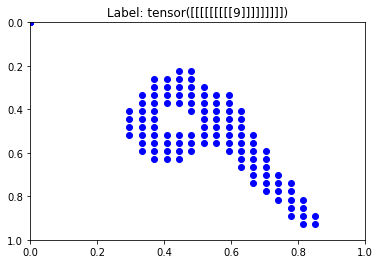

torch.Size([1, 2, 342])


In [61]:
dataset = MNISTSet(train=False, full=True)
expected3, sample3,mask_sample3 = dataset[7]
x = sample3[1, :]
y = sample3[0, :]
pyplot.scatter(x, y,color ='b')
pyplot.axis([0, 1, 1, 0])
pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()
sample3 = sample3.unsqueeze(0)
mask_sample3 = mask_sample3.unsqueeze(0)
expected3 = torch.tensor(expected3).unsqueeze(0)
print(sample3.shape)

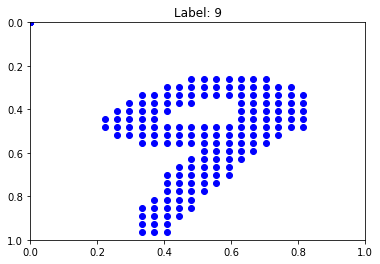

torch.Tensor

In [62]:
dataset = MNISTSet(train=False, full=True)
expected, sample,mask_sample = dataset[9]
x = sample[1, :]
y = sample[0, :]
pyplot.scatter(x, y,color ='b')
pyplot.axis([0, 1, 1, 0])
pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()
sample = sample.unsqueeze(0)
mask_sample = mask_sample.unsqueeze(0)
expected = torch.tensor(expected).unsqueeze(0)
type(sample)

In [111]:
with torch.no_grad():
    pred = miNet(sample,mask_sample)
    print("We obtained {}, and the expected is: {}".format(np.argmax(pred).item(),expected.item()))
    print(pred)
    pred1 = miNet(sample3,mask_sample3)
    print("We obtained {}, and the expected is: {}".format(np.argmax(pred1).item(),expected3.item()))
    print(pred1)

We obtained 9, and the expected is: 9
tensor([[ -6.8858,  -7.1283,  -4.0044,  -3.5007,  -1.8554,  -4.1452, -16.8203,
           4.4511,  -1.4342,   7.2078]])
We obtained 9, and the expected is: 9
tensor([[ -7.3784,  -1.7230,  -2.0763,  -7.8678,   3.3928,  -5.1589, -11.7785,
           0.8524,  -7.0557,   7.3642]])


In [112]:
class Model1(nn.Module):
    def __init__(self, input_channels, output_channels, dim, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(input_channels, dim, 1),
            nn.ReLU(inplace=True),
            nn.Conv1d(dim, dim, 1),
        )
        self.lin = nn.Sequential(
            nn.Linear(dim, dim, 1),
            nn.ReLU(inplace=True),
            nn.Linear(dim, output_channels, 1),
        )
        self.classifier = nn.Sequential(
            nn.Linear(output_channels, output_channels),
            nn.ReLU(),
            nn.Linear(output_channels, 10),
        )

    def forward(self, x, n_points, *args):
        x = self.conv(x)
        #x = x.max(2)[0]
        #x = self.lin(x)
        return x

In [113]:
class Model2(nn.Module):
    def __init__(self, input_channels, output_channels, dim, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(input_channels, dim, 1),
            nn.ReLU(inplace=True),
            nn.Conv1d(dim, dim, 1),
        )
        self.lin = nn.Sequential(
            nn.Linear(dim, dim, 1),
            nn.ReLU(inplace=True),
            nn.Linear(dim, output_channels, 1),
        )
        self.classifier = nn.Sequential(
            nn.Linear(output_channels, output_channels),
            nn.ReLU(),
            nn.Linear(output_channels, 10),
        )

    def forward(self, x, n_points, *args):
        x = self.conv(x)
        x = x.max(2)[0]
        #x = self.lin(x)
        return x

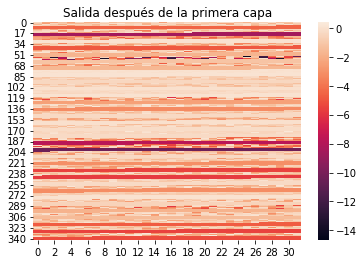

torch.Size([1, 32])


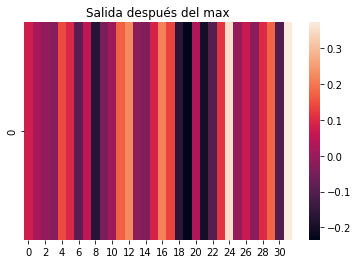

torch.Size([1, 32])


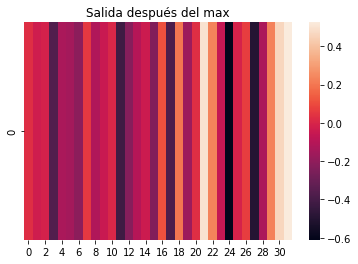

In [114]:
model1 = Model1(set_channels,latent_dim,hidden_dim)
model2 = Model2(set_channels,latent_dim,hidden_dim)
model1.conv = miNet.conv
model2.conv = miNet.conv
#print(miNet.conv[0].weight) 
#print(model1.conv[0].weight)
with torch.no_grad():
    pred = model1(sample,mask_sample)
    feature_map = pred
    data = pred.squeeze(0).detach().view(342,32).numpy()
    sn.heatmap(data, annot=False, fmt='g')
    pyplot.title("Salida después de la primera capa")
    pyplot.show()
    
    pred = model2(sample,mask_sample)
    max_map = pred
    print(pred.shape)
    data = pred.detach().numpy()
    sn.heatmap(data, annot=False, fmt='g')
    pyplot.title("Salida después del max")
    pyplot.show()
    
    pred = model2(sample3,mask_sample3)
    max_map = pred
    print(pred.shape)
    data = pred.detach().numpy()
    sn.heatmap(data, annot=False, fmt='g')
    pyplot.title("Salida después del max")
    pyplot.show()

In [115]:
critical = np.zeros(342)
features = feature_map.squeeze(0).detach().numpy()
maxs = max_map.squeeze(0).detach().numpy()
#print(features)
print('-----------------------------------------------------------------------------')
print(maxs)

for f in range(32):
    for p in range(342):
        if features[f,p] == maxs[f]:
            critical[p] =critical[p]+1
print(critical)
print(features.shape)
xmax = features.max(axis=1)
xmaxargs = features.argmax(axis=1)
xmaxargs.size

-----------------------------------------------------------------------------
[ 0.02747023 -0.03247949 -0.01207023 -0.36948347 -0.13183077 -0.14851674
 -0.20783196  0.05127144 -0.11654219 -0.0494963   0.00383991 -0.42060572
 -0.2274428  -0.10312256 -0.0390656  -0.23865552  0.10952422 -0.38389376
  0.20109549 -0.16728011  0.02718437  0.49539793  0.23015717 -0.06314653
 -0.6107793  -0.00815463  0.06617416 -0.49790332 -0.12971959  0.2272797
  0.4607392   0.5252607 ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6.

32

In [116]:
points = sample.squeeze(0).numpy()

In [117]:
sorted_critical = -np.sort(-critical)
sorted_critical_args = -np.argsort(-critical)
#print(sorted_critical_args)
K = 80
critical_points_x = []
critical_points_y = []
for k in range(K):
    critical_points_y.append(points[0,sorted_critical_args[k]])
    critical_points_x.append(points[1,sorted_critical_args[k]])

#criticos = critical_points.reshape(2,100)
#print(critical_points_x)
print(len(critical_points_x))
#print(critical_points_y)
print(np.sum(sorted_critical >0))
print(np.sum(sorted_critical == 6))

80
192
185


In [142]:
#Otro metodo
#print(sorted_critical_args)
K = 12
critical_points_ahmed_x = []
critical_points_ahmed_y = []
pr = np.sort(xmax)
prarg = np.sort(xmaxargs)
newxmaxargs = np.unique(xmaxargs)
print(prarg)
k = 17
for k in range(len(newxmaxargs)-5):
        critical_points_ahmed_y.append(points[0,newxmaxargs[k]])
        critical_points_ahmed_x.append(points[1,newxmaxargs[k]])
        #print(newxmaxargs[k])

#criticos = critical_points.reshape(2,100)
#print(critical_points_x)
print(len(critical_points_ahmed_x))

[  4   4  11  11  30  30  30  44  49  59  62  62  67  69  69  69  71  73
  73  84 121 121 134 142 147 155 157 157 157 157 157 157]
13


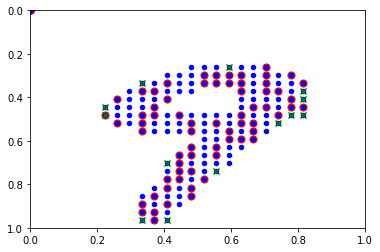

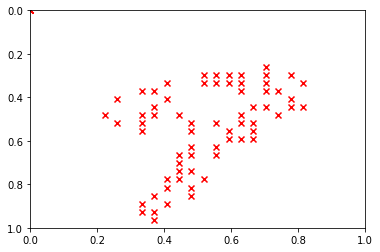

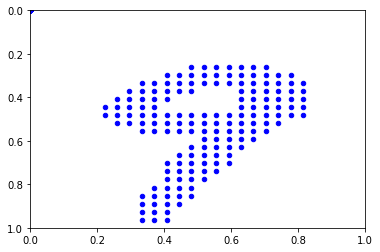

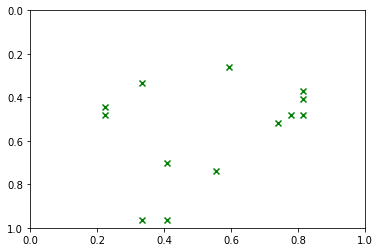

In [143]:
x1 = critical_points_x
y1 = critical_points_y
pyplot.scatter(x1, y1,marker='o',color ='r',s=50)
sam = sample.squeeze(0)
x = sam[1, :]
y = sam[0, :]
pyplot.scatter(x, y,c ='b',s=20)
x2 = critical_points_ahmed_x
y2 = critical_points_ahmed_y
pyplot.scatter(x2, y2,marker='x',color ='g')
pyplot.axis([0, 1, 1, 0])
pyplot.show()

x = critical_points_x
y = critical_points_y
pyplot.scatter(x, y,marker='x',color ='r')
pyplot.axis([0, 1, 1, 0])
pyplot.show()

sam = sample.squeeze(0)
x = sam[1, :]
y = sam[0, :]
pyplot.scatter(x, y,c ='b',s=20)
pyplot.axis([0, 1, 1, 0])
#pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()

x2 = critical_points_ahmed_x
y2 = critical_points_ahmed_y
pyplot.scatter(x2, y2,marker='x',color ='g')
pyplot.axis([0, 1, 1, 0])
pyplot.show()

In [144]:
muestraSintetica = torch.zeros(1,2,262)
a  = torch.Tensor(x1).unsqueeze(0)
k  = torch.Tensor(y1).unsqueeze(0)
print(k.shape)
f = torch.cat((k,a),0).unsqueeze(0)
print(f.shape)
muestraSintetica = torch.cat((f,muestraSintetica,),2)
muestraSintetica.shape
mask_sintetica = torch.ones(1,342)
print(muestraSintetica.shape)
print(mask_sintetica.shape)

torch.Size([1, 80])
torch.Size([1, 2, 80])
torch.Size([1, 2, 342])
torch.Size([1, 342])


In [87]:
342-18

324

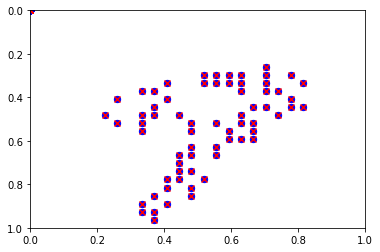

In [145]:
sam = muestraSintetica.squeeze(0)
x = sam[1, :]
y = sam[0, :]
pyplot.scatter(x, y,c ='b',s=40)
y1 = critical_points_y
x1 = critical_points_x
pyplot.scatter(x1, y1,marker='x',color ='r')
pyplot.axis([0, 1, 1, 0])
#pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()

In [146]:
with torch.no_grad():
    pred = miNet(muestraSintetica,mask_sintetica)
    print(muestraSintetica.shape)
    print(mask_sintetica.shape)
    print("We obtained {}, and the expected is: {}".format(np.argmax(pred).item(),expected.item()))
    print(pred)

torch.Size([1, 2, 342])
torch.Size([1, 342])
We obtained 9, and the expected is: 9
tensor([[ -9.3006,  -8.2177,  -4.9767,  -5.0293,   0.2147,  -3.1018, -15.5428,
           3.9535,  -1.5269,   5.9701]])


## Otro experimento

In [565]:
342 - 18

324

In [147]:
muestraSintetica = torch.zeros(1,2,325)
a  = torch.Tensor(x2).unsqueeze(0)
k  = torch.Tensor(y2).unsqueeze(0)
print(k.shape)
f = torch.cat((k,a),0).unsqueeze(0)
print(f.shape)
muestraSintetica = torch.cat((f,muestraSintetica,),2)
muestraSintetica.shape
mask_sintetica = torch.ones(1,342)
print(muestraSintetica.shape)
print(mask_sintetica.shape)

torch.Size([1, 13])
torch.Size([1, 2, 13])
torch.Size([1, 2, 338])
torch.Size([1, 342])


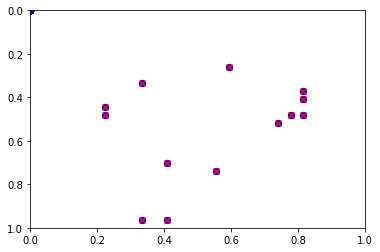

In [148]:
sam = muestraSintetica.squeeze(0)
x = sam[1, :]
y = sam[0, :]
pyplot.scatter(x, y,c ='b',s=40)
y1 = critical_points_ahmed_y
x1 = critical_points_ahmed_x
pyplot.scatter(x1, y1,marker='x',color ='r')
pyplot.axis([0, 1, 1, 0])
#pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()

In [149]:
with torch.no_grad():
    pred = miNet(muestraSintetica,mask_sintetica)
    print(muestraSintetica.shape)
    print(mask_sintetica.shape)
    print("We obtained {}, and the expected is: {}".format(np.argmax(pred).item(),expected.item()))
    print(pred)

torch.Size([1, 2, 338])
torch.Size([1, 342])
We obtained 9, and the expected is: 9
tensor([[ -6.6994,  -5.4239,  -2.5481,  -1.1678,  -2.9597,  -4.0855, -16.6080,
           3.8178,  -1.4706,   7.0283]])


## Como afecta el eliminar los puntos críticos

In [36]:
import random

newSample = sample.clone().detach() #b
crit= -sorted_critical_args[:80]
print(len(crit))
for k in crit:
    #print(k)
    newSample[:,0,k] = random.uniform(0, 1)
    newSample[:,1,k] = random.uniform(0, 1)
#print(newSample)

80


In [37]:
sample2 = sample2.unsqueeze(0)

In [38]:
import random

newSample2 = sample2.clone().detach() #b
crit2= xmaxargs[:32]
print(len(crit2))
for k in crit:
    #print(k)
    newSample2[:,0,k] = random.uniform(0, 1)
    newSample2[:,1,k] = random.uniform(0, 1)
#print(newSample2)

32


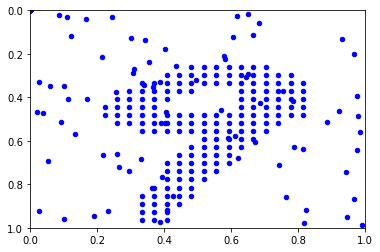

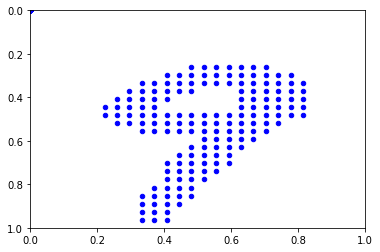

In [39]:
#En este trozo de código lo que hacemos es en las 80 primeras opciones criticas, ponemos valores aleatorios
n = newSample.squeeze(0)
x = n[1, :]
y = n[0, :]
pyplot.scatter(x, y,c ='b',s=20)
pyplot.axis([0, 1, 1, 0])
#pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()
n = sample.squeeze(0)
x = n[1, :]
y = n[0, :]
pyplot.scatter(x, y,c ='b',s=20)
pyplot.axis([0, 1, 1, 0])
#pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()

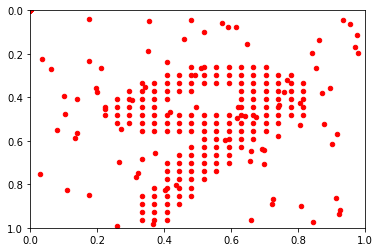

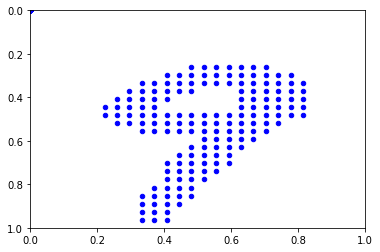

In [40]:
#En este trozo de código lo que hacemos es en las 80 primeras opciones criticas, ponemos valores aleatorios
n = newSample2.squeeze(0)
x = n[1, :]
y = n[0, :]
pyplot.scatter(x, y,c ='r',s=20)
pyplot.axis([0, 1, 1, 0])
#pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()
n = sample.squeeze(0)
x = n[1, :]
y = n[0, :]
pyplot.scatter(x, y,c ='b',s=20)
pyplot.axis([0, 1, 1, 0])
#pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()

In [41]:
with torch.no_grad():
    pred = miNet(newSample,mask_sintetica)
    print(muestraSintetica.shape)
    print(mask_sintetica.shape)
    print("We obtained {}, and the expected is: {}".format(np.argmax(pred).item(),expected.item()))

torch.Size([1, 2, 342])
torch.Size([1, 342])
We obtained 2, and the expected is: 9


In [76]:
with torch.no_grad():
    pred = miNet(newSample2,mask_sintetica)
    print(muestraSintetica.shape)
    print(mask_sintetica.shape)
    print("We obtained {}, and the expected is: {}".format(np.argmax(pred).item(),expected.item()))
    print(pred)

torch.Size([1, 2, 342])
torch.Size([1, 342])
We obtained 8, and the expected is: 9
tensor([[-1.1137, -5.8576,  1.9501, -1.2328, -3.0141, -2.2808, -9.9107, -4.0657,
          2.7805,  2.4136]])


## Comprobación de que funciona a la inversa, con los puntos menos informativos

In [43]:
sorted_noncritical = -np.sort(-critical)[::-1]
sorted_noncritical_args = -np.argsort(-critical)[::-1]
print(sorted_noncritical)
#print(sorted_critical_args)
K = 100
noncritical_points_x = []
noncritical_points_y = []
for k in range(K):
    noncritical_points_x.append(points[0,sorted_noncritical_args[k]])
    noncritical_points_y.append(points[1,sorted_noncritical_args[k]])

#criticos = critical_points.reshape(2,100)
#print(critical_points_x)
print(len(noncritical_points_x))
#print(critical_points_y)
print(np.sum(sorted_critical ==0))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 3. 3. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.

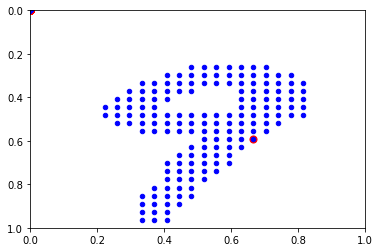

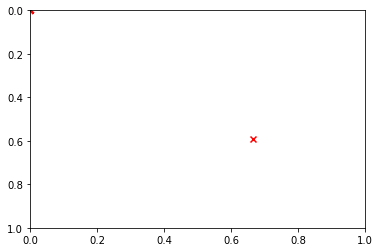

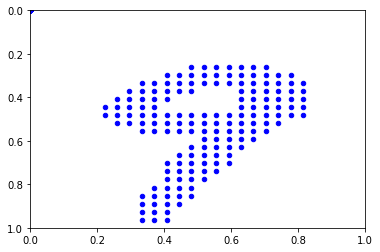

In [44]:
y1 = noncritical_points_x
x1 = noncritical_points_y
pyplot.scatter(x1, y1,marker='o',color ='r',s=50)
sam = sample.squeeze(0)
x = sam[1, :]
y = sam[0, :]
pyplot.scatter(x, y,c ='b',s=20)
pyplot.axis([0, 1, 1, 0])
pyplot.show()

y = noncritical_points_x
x = noncritical_points_y
pyplot.scatter(x, y,marker='x',color ='r')
pyplot.axis([0, 1, 1, 0])
pyplot.show()

sam = sample.squeeze(0)
x = sam[1, :]
y = sam[0, :]
pyplot.scatter(x, y,c ='b',s=20)
pyplot.axis([0, 1, 1, 0])
#pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()